In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import h5py
from collections import defaultdict

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.metrics import Recall, Precision, MeanAbsoluteError
from tensorflow.keras.utils import plot_model

In [3]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")

In [4]:
# Set up folder paths
# Define the source paths for images and annotations
image_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'JPEGImages')
annot_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'Annotations')

# Define the destination path for images and annotations
image_dest_path = os.path.join(working_path, 'data', 'Images')
annot_dest_path = os.path.join(working_path, 'data', 'Annotations')

# Define the destination path for bboxes and masks
bb_path = os.path.join(working_path, 'data', 'Images_bb')
mask_path = os.path.join(working_path, 'data', 'Pixel_masks')

# Define the destination path for csv file
csv_path = os.path.join(working_path, 'data', 'csv')

In [5]:
image_dataset_path = image_dest_path

In [6]:
csv_bounding_boxes = (f'{csv_path}\\PCB_annotations_dataset.csv')
images = os.listdir(image_dataset_path)

In [7]:
df = pd.read_csv(csv_bounding_boxes, sep=";")

In [8]:
bounding_boxes_data = pd.read_csv(csv_bounding_boxes, sep=";")

image_data = []
class_labels = []
mask_data= []

grouped_bbox = bounding_boxes_data.groupby('filename')

In [9]:
image_data = []
mask_data = []
class_labels = []

for filename in images:
   
    image_path = os.path.join(image_dataset_path, filename)
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (600, 600))  
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_array = np.asarray(gray_image) / 255.0 
    image_data.append(image_array)

    filename = os.path.splitext(filename)[0]
        
    mask = np.zeros((600, 600), dtype=np.uint8)

    if filename in grouped_bbox.groups:
        image_bbox_df = grouped_bbox.get_group(filename)

        for index, row in image_bbox_df.iterrows():
            class_label = row['defect']
        
            xmin, ymin, xmax, ymax = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] 
            #mask_color = class_to_color[class_label]
            mask[ymin:ymax, xmin:xmax] = 255 #mask_color 
    
    mask = np.asarray(mask) / 255.0

    mask_array = np.asarray(mask)
            
    mask_data.append(mask_array)
    
    class_labels.append(class_label)

X_images = np.array(image_data)
y_bounding_boxes = np.array(mask_data)
y_class_labels = np.array(class_labels)

# class_label_mapping = {label: index for index, label in enumerate(np.unique(class_labels))}
# y_class_labels_numeric = np.array([class_label_mapping[label] for label in class_labels])

# num_classes = len(class_label_mapping)
# y_categorical = to_categorical(y_class_labels_numeric, num_classes=num_classes)


In [10]:
print(X_images.shape)
print(y_bounding_boxes.shape)
print(y_class_labels.shape)

(1777, 600, 600)
(1777, 600, 600)
(1777,)


In [107]:
new_size = (200, 200)

cropped_images_int = []
cropped_masks_int = []
cropped_y_class_labels_int = []

threshold = 210  

for image, mask, labels in zip(X_images, y_bounding_boxes, y_class_labels):
    for y in range(0, 600, new_size[0]):
        for x in range(0, 600, new_size[0]):
            patch_image = image[y:y+new_size[0], x:x+new_size[0]]
            patch_mask = mask[y:y+new_size[0], x:x+new_size[0]]

            if np.any(patch_mask):
                if np.sum(patch_mask) > threshold:
                    cropped_images_int.append(patch_image)
                    cropped_masks_int.append(patch_mask)
                    cropped_y_class_labels_int.append(labels)
                else:
                    cropped_images_int.append(patch_image)
                    cropped_masks_int.append(patch_mask)
                    cropped_y_class_labels_int.append("none")

cropped_images = np.array(cropped_images_int)
cropped_masks = np.array(cropped_masks_int)
cropped_y_class_labels = np.array(cropped_y_class_labels_int)

print(cropped_images.shape)
print(cropped_masks.shape)
print(cropped_y_class_labels.shape)

(3891, 200, 200)
(3891, 200, 200)
(3891,)


In [108]:
def plot_images(images, masks, labels, num_samples=6):
    _ , axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.ravel()
    sample_indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].imshow(masks[idx], alpha=0.5, cmap='jet')
        axes[i].set_title(f'Label: {labels[idx]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



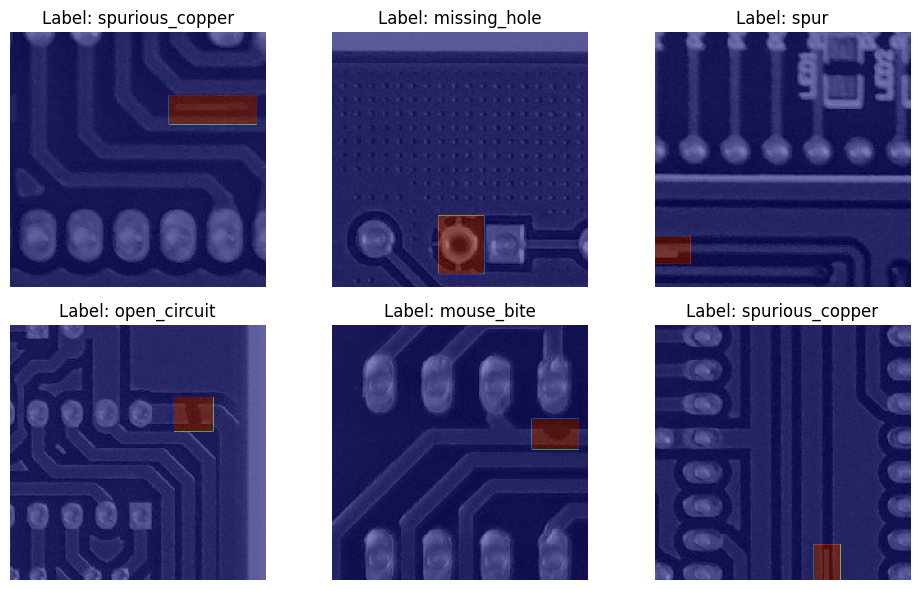

In [109]:
# Plot random 6 images
plot_images(cropped_images, cropped_masks, cropped_y_class_labels)

In [110]:
unique_labels, label_counts = np.unique(cropped_y_class_labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 611
Label: mouse_bite, Count: 622
Label: none, Count: 346
Label: open_circuit, Count: 552
Label: short, Count: 632
Label: spur, Count: 326
Label: spurious_copper, Count: 802


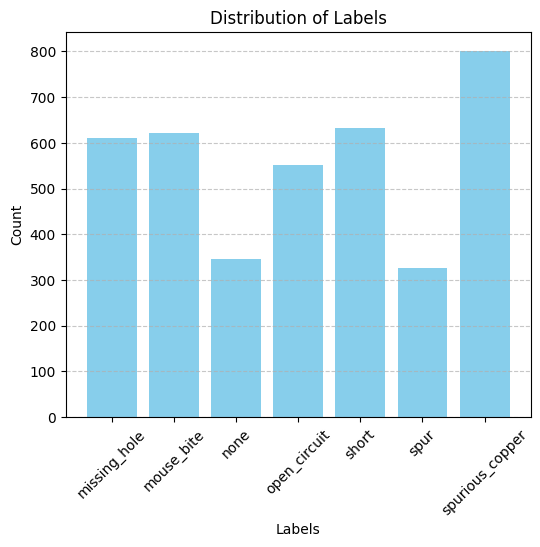

In [111]:
plt.figure(figsize=(6, 5))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

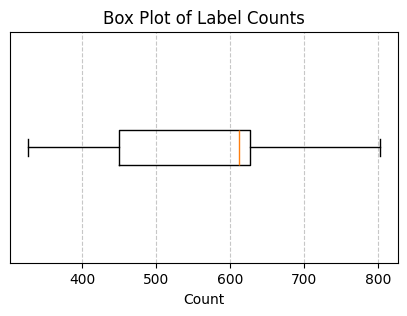

In [112]:
plt.figure(figsize=(5, 3))
plt.boxplot(label_counts, vert=False)
plt.yticks([])
plt.xlabel('Count')
plt.title('Box Plot of Label Counts')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The above distribution of data is clearly unbalanced, so we need to balance out the data by introducing more images to even out the distribution or to delete some data.

In [114]:
max_samples_per_class = 100

In [115]:
label_counts = defaultdict(int)

# Count the occurrences of each label
for label in cropped_y_class_labels:
    label_counts[label] += 1

# Filter out extra samples for each class label
filtered_images = []
filtered_masks = []
filtered_labels = []

for label in set(cropped_y_class_labels):
    label_indices = [i for i, l in enumerate(cropped_y_class_labels) if l == label]
    if len(label_indices) > max_samples_per_class:
        selected_indices = random.sample(label_indices, max_samples_per_class)
    else:
        selected_indices = label_indices
    filtered_images.extend(cropped_images[selected_indices])
    filtered_masks.extend(cropped_masks[selected_indices])
    filtered_labels.extend(cropped_y_class_labels[selected_indices])

# Convert the filtered lists to arrays
filtered_images = np.array(filtered_images)
filtered_masks = np.array(filtered_masks)
filtered_labels = np.array(filtered_labels)

In [116]:
# Print the shape of filtered data
print("Filtered Images Shape:", filtered_images.shape)
print("Filtered Masks Shape:", filtered_masks.shape)
print("Filtered Labels Shape:", filtered_labels.shape)

Filtered Images Shape: (700, 200, 200)
Filtered Masks Shape: (700, 200, 200)
Filtered Labels Shape: (700,)


In [117]:
filtered_unique_labels, filtered_label_counts = np.unique(filtered_labels, return_counts=True)

for label, count in zip(filtered_unique_labels, filtered_label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 100
Label: mouse_bite, Count: 100
Label: none, Count: 100
Label: open_circuit, Count: 100
Label: short, Count: 100
Label: spur, Count: 100
Label: spurious_copper, Count: 100


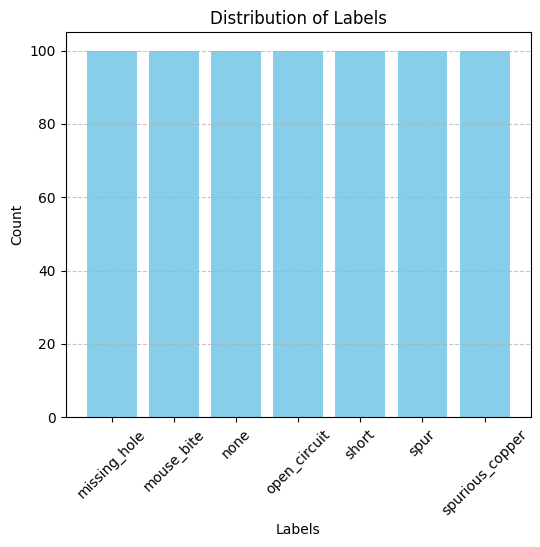

In [118]:
plt.figure(figsize=(6, 5))
plt.bar(filtered_unique_labels, filtered_label_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

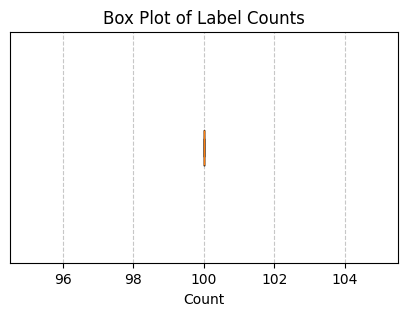

In [119]:
plt.figure(figsize=(5, 3))
plt.boxplot(filtered_label_counts, vert=False)
plt.yticks([])
plt.xlabel('Count')
plt.title('Box Plot of Label Counts')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

After including more images (along with the coresponding masks and labels) and deleting surplus data, the dataset is more balanced.

In [120]:
for i, label in enumerate(filtered_labels):
    # Check if the label is "none"
    if label == "none":
        # Replace the corresponding mask image with a blank image
        filtered_masks[i] = np.zeros_like(filtered_masks[i])

In [121]:
encoder = LabelEncoder()

y_class_labels_encoded = encoder.fit_transform(filtered_labels)
filtered_y_categorical = to_categorical(y_class_labels_encoded)

In [122]:
combined_data = []

combined_data = list(zip(filtered_images, filtered_masks, filtered_y_categorical))

Labels: [0. 0. 1. 0. 0. 0. 0.]


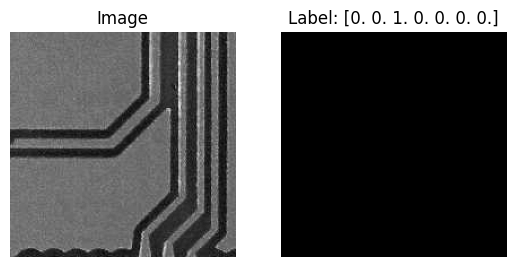

In [132]:
np.random.shuffle(combined_data)
for images, masks, labels in combined_data:
    
    print("Labels:", labels)

    plt.subplot(1, 2, 1)
    plt.imshow(images.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks.squeeze(), cmap='gray')

    plt.title(f'Label: {labels}') 

    plt.axis('off')
    plt.show()

    break 

In [133]:
print(filtered_images.shape)
print(filtered_masks.shape)
print(filtered_y_categorical.shape)

print(filtered_labels.shape)
print(filtered_label_counts.shape)

(700, 200, 200)
(700, 200, 200)
(700, 7)
(700,)
(7,)


In [134]:
# Split data into train and validation sets
X_train, X_test, y_train_mask, y_test_mask, y_train_class, y_test_class= train_test_split(filtered_images, filtered_masks, filtered_y_categorical, 
                                                                                                      test_size=0.2, random_state=42)

In [138]:
print("X_train shape:", X_train.shape)
print("y_train_bbox shape:", y_train_mask.shape)
print("y_train_categorical shape:", y_train_class.shape)
print("X_test shape:", X_test.shape)
print("y_test_bbox shape:", y_test_mask.shape)
print("y_test_categorical shape:", y_test_class.shape)

X_train shape: (560, 200, 200)
y_train_bbox shape: (560, 200, 200)
y_train_categorical shape: (560, 7)
X_test shape: (140, 200, 200)
y_test_bbox shape: (140, 200, 200)
y_test_categorical shape: (140, 7)


In [149]:
# Data Augmentation:
# rotation ,width_shift, height_shift, shear, zoom, horizontal_flip
none_label = np.array([0, 0, 1, 0, 0, 0, 0])
def augment_data(images, masks, labels):
    augmented_images = []
    augmented_masks = []
    augmented_labels = []

    for image, mask, labels in zip(images, masks, labels):
        augmented_images.append(image)
        augmented_masks.append(mask)
        augmented_labels.append(labels)

        shear_image, shear_mask = shear(image, mask)
        if np.sum(shear_mask) > threshold:
            augmented_images.append(shear_image)
            augmented_masks.append(shear_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(shear_image)
            augmented_masks.append(shear_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(shear_image)
        # augmented_masks.append(shear_mask)
        # augmented_labels.append(labels)
        # print("Shear:", shear_image.shape, shear_mask.shape)

        flip_image, flip_mask = flip(image, mask)
        if np.sum(flip_mask) > threshold:
            augmented_images.append(flip_image)
            augmented_masks.append(flip_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(flip_image)
            augmented_masks.append(flip_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(flip_image)
        # augmented_masks.append(flip_mask)
        # augmented_labels.append(labels)
        # print("Flip:", flip_image.shape, flip_mask.shape)

        zoom_image, zoom_mask = zoom(image, mask)
        if np.sum(zoom_mask) > threshold:
            augmented_images.append(zoom_image)
            augmented_masks.append(zoom_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(zoom_image)
            augmented_masks.append(zoom_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(zoom_image)
        # augmented_masks.append(zoom_mask)
        # augmented_labels.append(labels)
        # print("Zoom:", zoom_image.shape, zoom_mask.shape)

        width_shift_image, width_shift_mask = width_shift(image, mask)
        if np.sum(width_shift_mask) > threshold:
            augmented_images.append(width_shift_image)
            augmented_masks.append(width_shift_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(width_shift_image)
            augmented_masks.append(width_shift_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(width_shift_image)
        # augmented_masks.append(width_shift_mask)
        # augmented_labels.append(labels)
        # print("Width Shift:", width_shift_image.shape, width_shift_mask.shape)

        height_shift_image, height_shift_mask = height_shift(image, mask)
        if np.sum(height_shift_mask) > threshold:
            augmented_images.append(height_shift_image)
            augmented_masks.append(height_shift_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(height_shift_image)
            augmented_masks.append(height_shift_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(height_shift_image)
        # augmented_masks.append(height_shift_mask)
        # augmented_labels.append(labels)
        # print("Height Shift:", height_shift_image.shape, height_shift_mask.shape)

        rotate_image, rotate_mask = rotate(image, mask)
        if np.sum(rotate_mask) > threshold:
            augmented_images.append(rotate_image)
            augmented_masks.append(rotate_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(rotate_image)
            augmented_masks.append(rotate_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(rotate_image)
        # augmented_masks.append(rotate_mask)
        # augmented_labels.append(labels)
        # print("Rotation:", rotate_image.shape, rotate_mask.shape)

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_masks, augmented_labels

def shear(image, mask):
    shear_factor = np.random.uniform(-0.2, 0.2)
    rows, cols = image.shape[:2]
    shear_matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    shear_image = cv2.warpAffine(image, shear_matrix, (cols, rows))
    shear_mask = cv2.warpAffine(mask, shear_matrix, (cols, rows))

    padded_image = np.zeros((new_size[0], new_size[0]), dtype=np.uint8)
    padded_mask = np.zeros((new_size[0], new_size[0]), dtype=np.uint8)
    padded_image[:rows, :cols] = shear_image
    padded_mask[:rows, :cols] = mask

    return shear_image, shear_mask

def flip(image, mask):
    flip_image = cv2.flip(image, 1)
    flip_mask = cv2.flip(mask, 1)
    return flip_image, flip_mask

def zoom(image, mask):
    zoom_factor = np.random.uniform(0.8, 1.2)
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    zoomed_mask = cv2.resize(mask, None, fx=zoom_factor, fy=zoom_factor)

    rows, cols = zoomed_image.shape[:2]
    if rows < new_size[0] or cols < new_size[0]:
        pad_rows = max(0, (new_size[0] - rows) // 2)
        pad_cols = max(0, (new_size[0] - cols) // 2)
        zoomed_image = cv2.copyMakeBorder(zoomed_image, pad_rows, new_size[0] - rows - pad_rows, pad_cols, new_size[0] - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
        zoomed_mask = cv2.copyMakeBorder(zoomed_mask, pad_rows, new_size[0] - rows - pad_rows, pad_cols, new_size[0] - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
    elif rows > new_size[0] or cols > new_size[0]:
        zoomed_image = zoomed_image[:new_size[0], :new_size[0]]
        zoomed_mask = zoomed_mask[:new_size[0], :new_size[0]]

    return zoomed_image, zoomed_mask

def width_shift(image, mask):
    shift_x = np.random.uniform(-0.2, 0.2) * image.shape[1]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, 0]])
    width_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    width_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if width_shift_image.shape[1] > new_size[0]:
        width_shift_image = width_shift_image[:, :new_size[0]]
        width_shift_mask = width_shift_mask[:, :new_size[0]]
    elif width_shift_image.shape[1] < new_size[0]:
        pad_width = new_size[0] - width_shift_image.shape[1]
        width_shift_image = np.pad(width_shift_image, ((0, 0), (0, pad_width), (0, 0)), mode='constant')
        width_shift_mask = np.pad(width_shift_mask, ((0, 0), (0, pad_width), (0, 0)), mode='constant')

    return width_shift_image, width_shift_mask

def height_shift(image, mask):
    shift_y = np.random.uniform(-0.2, 0.2) * image.shape[0]
    translation_matrix = np.float32([[1, 0, 0], [0, 1, shift_y]])
    height_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    height_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if height_shift_image.shape[0] > new_size[0]:
        height_shift_image = height_shift_image[:new_size[0], :]
        height_shift_mask = height_shift_mask[:new_size[0], :]
    elif height_shift_image.shape[0] < new_size[0]:
        pad_height = new_size[0] - height_shift_image.shape[0]
        height_shift_image = np.pad(height_shift_image, ((0, pad_height), (0, 0), (0, 0)), mode='constant')
        height_shift_mask = np.pad(height_shift_mask, ((0, pad_height), (0, 0), (0, 0)), mode='constant')

    return height_shift_image, height_shift_mask

def rotate(image, mask):
    angle = np.random.uniform(-20, 20)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotate_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    rotate_mask = cv2.warpAffine(mask, rotation_matrix, (cols, rows))

    if rotate_image.shape[0] > new_size[0] or rotate_image.shape[1] > new_size[0]:
        rotate_image = cv2.resize(rotate_image, (new_size[0], new_size[0]))
        rotate_mask = cv2.resize(rotate_mask, (new_size[0], new_size[0]))
    elif rotate_image.shape[0] < new_size[0] or rotate_image.shape[1] < new_size[0]:
        pad_height = max(0, new_size[0] - rotate_image.shape[0])
        pad_width = max(0, new_size[0] - rotate_image.shape[1])
        rotate_image = np.pad(rotate_image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        rotate_mask = np.pad(rotate_mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    return rotate_image, rotate_mask


In [150]:
X_train_augmented_int, y_train_mask_augmented_int, y_train_class_augmented_int = augment_data(X_train, y_train_mask, y_train_class)

In [152]:
for i, label in enumerate(y_train_class_augmented_int):
    # Check if the label is "none"
    if np.array_equal(label, [0, 0, 1, 0, 0, 0, 0]):
        # Replace the corresponding mask image with a blank image
        y_train_mask_augmented_int[i] = np.zeros_like(y_train_mask_augmented_int[i])

In [154]:
print(y_train_class_augmented_int)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [157]:
augmented_classes = np.argmax(y_train_class_augmented_int, axis=1)

In [158]:
y_train_unique_labels, y_train_label_counts = np.unique(augmented_classes, return_counts=True)

for label, count in zip(y_train_unique_labels, y_train_label_counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 497
Label: 1, Count: 547
Label: 2, Count: 689
Label: 3, Count: 532
Label: 4, Count: 575
Label: 5, Count: 553
Label: 6, Count: 527


After data augmentation, more imbalance is introduced, we will offset this be minimizing our classes to 500 points of data per class.

In [161]:
max_samples_per_augmented_class = 500

label_counts = defaultdict(int)

# Count the occurrences of each label
for label in augmented_classes:
    label_counts[label] += 1

# Filter out extra samples for each class label
x_train_filtered_images = []
y_train_filtered_mask = []
y_train_filtered_labels = []

for label in set(augmented_classes):
    label_indices = [i for i, l in enumerate(augmented_classes) if l == label]
    if len(label_indices) > max_samples_per_augmented_class:
        selected_indices = random.sample(label_indices, max_samples_per_augmented_class)
    else:
        selected_indices = label_indices
    x_train_filtered_images.extend(X_train_augmented_int[selected_indices])
    y_train_filtered_mask.extend(y_train_mask_augmented_int[selected_indices])
    y_train_filtered_labels.extend(y_train_class_augmented_int[selected_indices])

# Convert the filtered lists to arrays
x_train_filtered_images = np.array(x_train_filtered_images)
y_train_filtered_mask = np.array(y_train_filtered_mask)
y_train_filtered_labels = np.array(y_train_filtered_labels)

In [163]:
augmented_classes_filtered = np.argmax(y_train_filtered_labels, axis=1)

In [164]:
y_train_unique_labels, y_train_label_counts = np.unique(augmented_classes_filtered, return_counts=True)

for label, count in zip(y_train_unique_labels, y_train_label_counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 497
Label: 1, Count: 500
Label: 2, Count: 500
Label: 3, Count: 500
Label: 4, Count: 500
Label: 5, Count: 500
Label: 6, Count: 500


In [165]:
combined_data2 = []

combined_data2 = list(zip(x_train_filtered_images, y_train_filtered_mask, y_train_filtered_labels))

Labels: [0. 1. 0. 0. 0. 0. 0.]


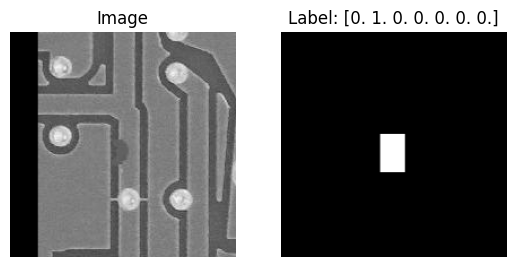

In [185]:
np.random.shuffle(combined_data2)
for images, masks, labels in combined_data2:
    
    print("Labels:", labels)

    plt.subplot(1, 2, 1)
    plt.imshow(images.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks.squeeze(), cmap='gray')

    plt.title(f'Label: {labels}') 

    plt.axis('off')
    plt.show()

    break 

In [186]:
print("X_train shape:", X_train.shape)
print("y_train_bbox shape:", y_train_mask.shape)
print("y_train_categorical shape:", y_train_class.shape)

print("X_train_augmented shape:", x_train_filtered_images.shape)
print("y_train_augmented shape:", y_train_filtered_mask.shape)
print("y_train_categorical_augmented shape:", y_train_filtered_labels.shape)

X_train shape: (560, 200, 200)
y_train_bbox shape: (560, 200, 200)
y_train_categorical shape: (560, 7)
X_train_augmented shape: (3497, 200, 200)
y_train_augmented shape: (3497, 200, 200)
y_train_categorical_augmented shape: (3497, 7)


In [187]:
# to save the filtered, augmented dataset to disk
def save_data_to_disk(X, y_mask, y_class, filepath):
    with h5py.File(filepath, 'w') as hf:
        hf.create_dataset('X', data=X)
        hf.create_dataset('y_mask', data=y_mask)
        hf.create_dataset('y_class', data=y_class)

In [188]:
downloads_path = os.path.expanduser("~/Downloads")
file_name = "filtered_augmented_data.h5"
file_path = os.path.join(downloads_path, file_name)

save_data_to_disk(x_train_filtered_images, y_train_filtered_mask, y_train_filtered_labels, file_path)

Initializing functions for deep learning model

In [189]:
class TimingCallback(Callback):
    def __init__(self, max_duration_seconds, logs={}):
        self.logs=[]
        self.max_duration_seconds = max_duration_seconds
            
    def on_train_begin(self, logs={}):
        self.start_time = timer()
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        total_duration = timer() - self.start_time
        if total_duration > self.max_duration_seconds:
            print(f"Stopping training after {total_duration / 3600} hours")
            self.model.stop_training = True


In [190]:
early_stopping = EarlyStopping(
                                patience=5, 
                                min_delta = 0.005, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=5, 
                                    episilon= 0.005,
                                    factor=0.1,  
                                    cooldown = 4, 
                                    verbose=1)

time_callback = TimingCallback(10800)

In [198]:
def elegant_unet_segmentation_classification(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # connections
    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        return x

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.DepthwiseConv2D(3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 1, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', dilation_rate=2, padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # Classification Route
    flatten = layers.GlobalAveragePooling2D()(conv3)
    dense1 = layers.Dense(128, activation='relu')(flatten)
    dropout = layers.Dropout(0.5)(dense1)

    # Classification Output
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(dropout)

    # Segmentation Route
    # Decoder
    up1 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = conv_block(up1, 128)

    up2 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = conv_block(up2, 64)

    # Segmentation Output
    segmentation_output = layers.Conv2D(1, 1, activation='sigmoid', name='segmentation_output')(conv5)

    # Create Model
    model = models.Model(inputs=inputs, 
                         outputs=[segmentation_output, 
                                  classification_output
                                  ])
    return model


In [199]:
num_classes=len(labels)
print(num_classes)

7


In [200]:
# Instantiate the model
model = elegant_unet_segmentation_classification(input_shape=(new_size[0], new_size[0], 1), num_classes=num_classes)

In [201]:
# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'segmentation_output': 'binary_crossentropy',  # for the mask output with sigmoid 
        'classification_output': 'categorical_crossentropy'  # for the classification output with softmax
    },
    loss_weights={
        'segmentation_output': 0.7,  # Weighted at 70%
        'classification_output': 0.3  # Weighted at 30%
    },
    metrics={
        'segmentation_output': ['accuracy', MeanAbsoluteError()],  # Adding MAE for mask
        'classification_output': ['accuracy', Recall(), Precision()]  # Metrics for classification
    }
)

In [202]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 200, 200,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 200, 200,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 100, 100,  │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 100, 100,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 50, 50,    │      1,280 │ max_pooling2d_3[… │
│ (DepthwiseConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 50, 50,    │     33,024 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │      1,024 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 50, 50,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │      1,024 │ conv2d_19[0][0] 

 Total params: 1,640,264 (6.26 MB)

 Trainable params: 1,637,448 (6.25 MB)

 Non-trainable params: 2,816 (11.00 KB)

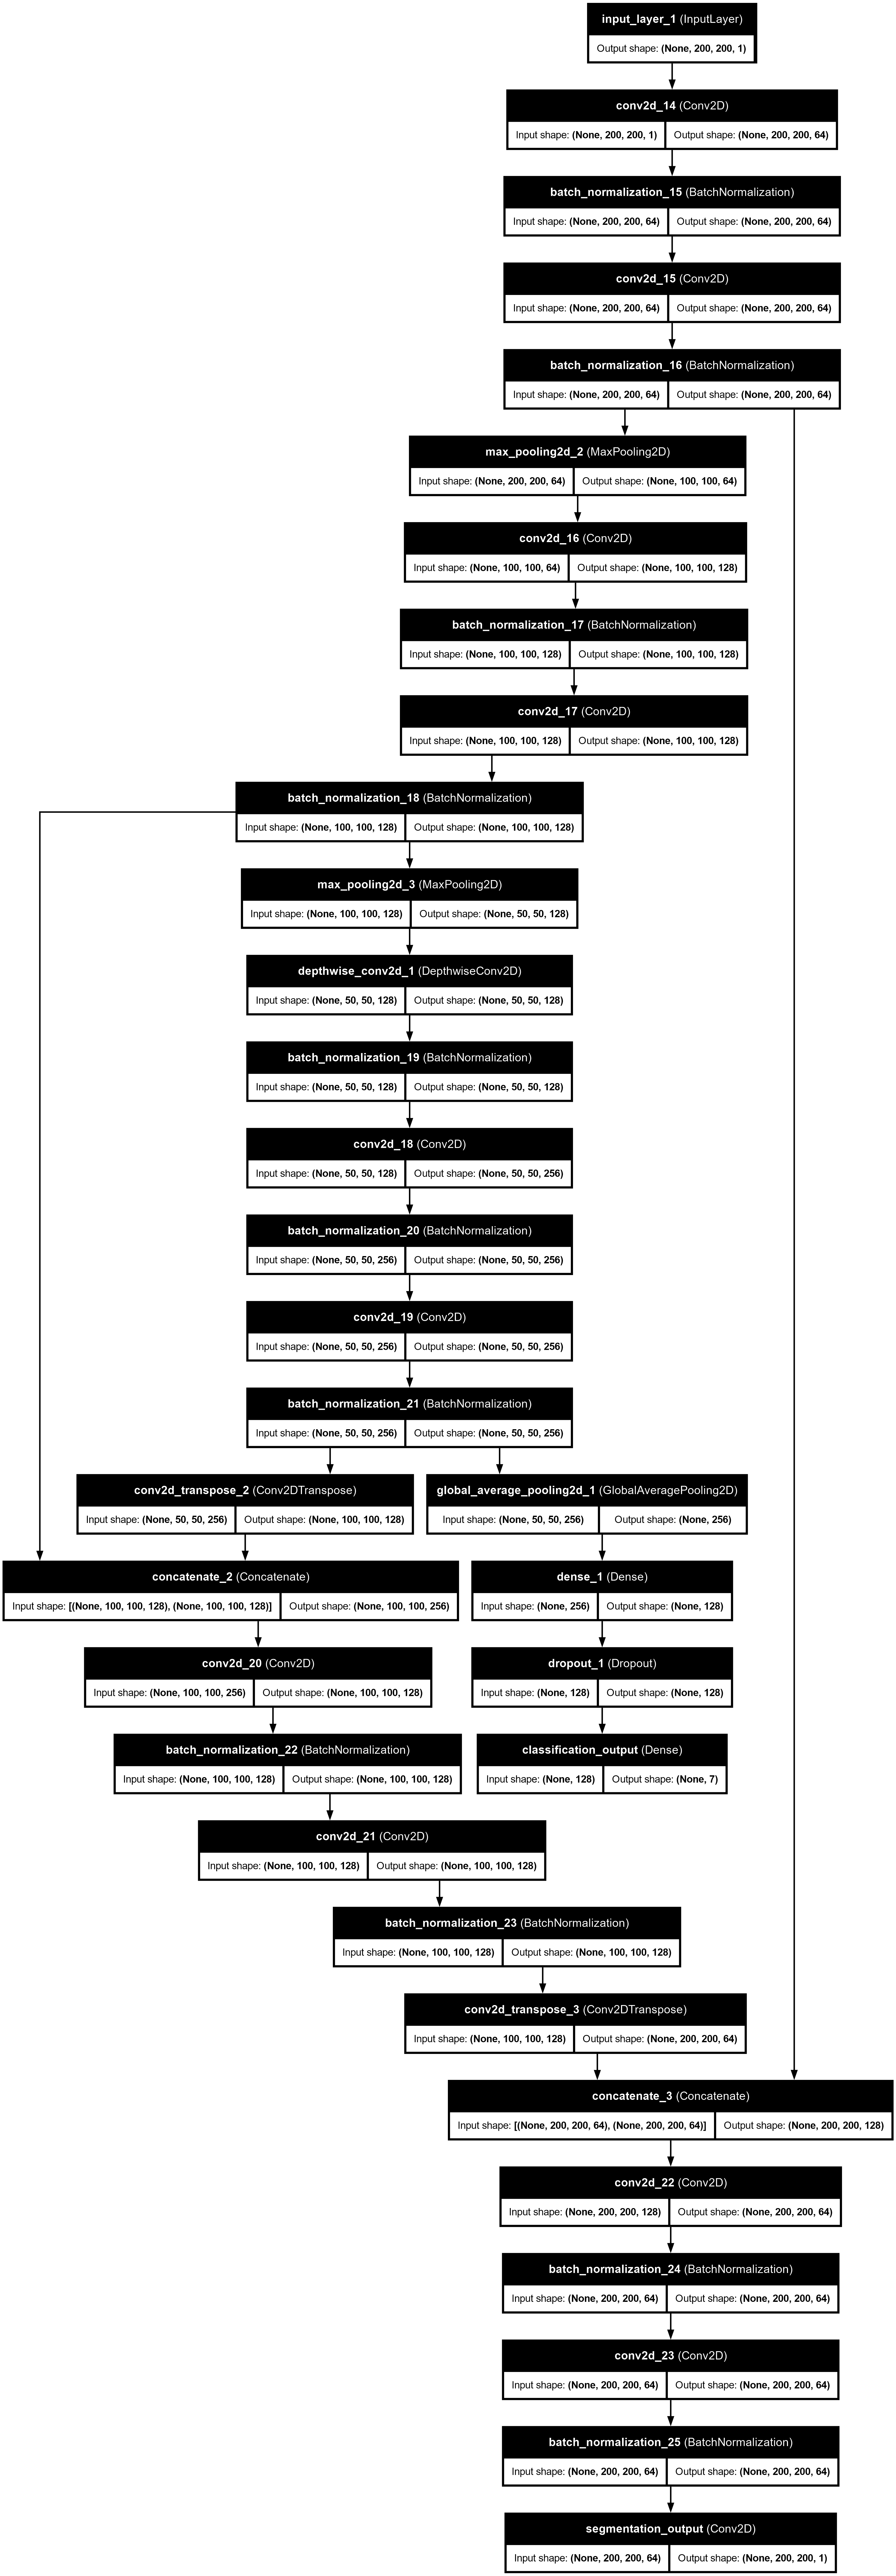

In [203]:
plot_model(model, to_file='model_elegant_testing.png', show_shapes=True, show_layer_names=True)

In [205]:
print("X_train_augmented shape:", X_train_augmented_int.shape)
print("y_train_augmented shape:", y_train_class_augmented_int.shape)
print("y_train_categorical_augmented shape:", y_train_class_augmented_int.shape)
print("Expected input shape for the model:", model.input_shape)

print("Model output shape:", model.output_shape)

print("Data type of y_train_augmented:", y_train_class_augmented_int.dtype)

X_train_augmented shape: (3920, 200, 200)
y_train_augmented shape: (3920, 7)
y_train_categorical_augmented shape: (3920, 7)
Expected input shape for the model: (None, 200, 200, 1)
Model output shape: [(None, 200, 200, 1), (None, 7)]
Data type of y_train_augmented: float64


In [42]:
# Train the model
history = model.fit(x=X_train_augmented_int, 
                    y=[y_train_mask_augmented_int, y_train_class_augmented_int],
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, [y_test_mask, y_test_class]),
                    #callbacks=[ reduce_learning_rate, 
                     #           early_stopping, 
                      #          time_callback],
                    verbose=True)

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 4397s 18s/step - classification_output_accuracy: 0.1724 - classification_output_precision: 0.2259 - classification_output_recall: 0.0049 - loss: 0.8863 - segmentation_output_accuracy: 0.8837 - segmentation_output_mean_absolute_error: 0.2813 - val_classification_output_accuracy: 0.1643 - val_classification_output_precision: 0.0000e+00 - val_classification_output_recall: 0.0000e+00 - val_loss: 0.7265 - val_segmentation_output_accuracy: 0.9803 - val_segmentation_output_mean_absolute_error: 0.0332
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 4446s 18s/step - classification_output_accuracy: 0.2385 - classification_output_precision: 0.5021 - classification_output_recall: 0.0067 - loss: 0.6232 - segmentation_output_accuracy: 0.9815 - segmentation_output_mean_absolute_error: 0.0409 - val_classification_output_accuracy: 0.1321 - val_classification_output_precision: 0.0000e+00 - val_classification_output_recall: 0.0000e+00 - val_loss: 0.7073 - val_segmentation_

In [1]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_enhanced_unet_training_history_on_200.csv', index=False)
model.save('model_enhanced_unet_200.keras')
model.save('model_enhanced_unet_200.h5')

NameError: name 'pd' is not defined